# Assignment 3 Data Analysis via Pandas

Get an experimentally informed connection matrix from from http://hippocampome.org/netlist
Or an excell spreadsheet of similar origin.

https://collab.humanbrainproject.eu/#/collab/5458/nav/42545


In [1]:
!pip install pyNN
threads  = 8
rngseed  = 98765
parallel_safe = True

threads = 8
extra = {'threads' : threads,'label': 'VA'}
#if simulator == "neuroml":
#    extra["file"] = "VAbenchmarks.xml"

# Perform some system admin
import matplotlib.pyplot as plt

import os
import pandas as pd
import sys
import matplotlib as mpl
%matplotlib inline
mpl.rcParams.update({'font.size':16})
installs = ['bbp_client','neuron','mpi4py','xlrd','pyNN','seaborn','lazyarray','neo','neuron','brian2']
def install_deps(i):
  '''
  Hack in dependencies into to sys.path
  '''
  import os
  if i not in sys.path:
    os.system('pip install '+str(i))    

_ = list(map(install_deps,installs))
import os

#Compile NEUORN mod files.
temp = os.getcwd()
os.chdir('/opt/conda/lib/python3.5/site-packages/pyNN/neuron/nmodl')
!nrnivmodl
os.chdir(temp)







You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/opt/conda/lib/python3.5/site-packages/pyNN/neuron/nmodl
ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod adexp.mod alphaisyn.mod alphasyn.mod expisyn.mod gammastim.mod gap.mod gif.mod gsfa_grr.mod hh_traub.mod izhikevich.mod netstim2.mod poisson_stim_refractory.mod quantal_stp.mod refrac.mod reset.mod stdwa_guetig.mod stdwa_softlimits.mod stdwa_songabbott.mod stdwa_symm.mod stdwa_vogels2011.mod stochastic_synapse.mod stochastic_tsodyksmarkram.mod tmgsyn.mod tmisyn.mod tsodyksmarkram.mod vecstim.mod
ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod adexp.mod alphaisyn.mod alphasyn.mod expisyn.mod gammastim.mod gap.mod gif.mod gsfa_grr.mod hh_traub.mod izhikevich.mod netstim2.mod poisson_stim_refractory.mod quantal_stp.mod refrac.mod reset.mod stdwa_guetig.mod stdwa_softlimits.mod stdwa_songabbott.mod stdwa_symm.mod stdwa_vogels2011.mod stochastic_synapse.mod stoc

In [2]:
# Get some hippocampus connectivity data, based on a conversation with
# academic researchers on GH:
# https://github.com/Hippocampome-Org/GraphTheory/issues?q=is%3Aissue+is%3Aclosed
# scrape hippocamome connectivity data, that I intend to use to program neuromorphic hardware.
# conditionally get files if they don't exist.
'''
path_xl = '_hybrid_connectivity_matrix_20171103_092033.xlsx'
if not os.path.exists(path_xl):
    os.system('wget https://github.com/Hippocampome-Org/GraphTheory/files/1657258/_hybrid_connectivity_matrix_20171103_092033.xlsx')

xl = pd.ExcelFile(path_xl)
dfEE = xl.parse()
dfEE.loc[0].keys()
dfm = dfEE.as_matrix()
filtered = dfm[:,3:]
filtered = filtered[1:]
'''



In [3]:

import numpy as np
from pyNN.neuron import STDPMechanism
import copy
EElist = []
IIlist = []
from pyNN.random import RandomDistribution, NumpyRNG

rng = NumpyRNG(seed=64754)
delay_distr = RandomDistribution('normal', [35, 1e-3], rng=rng)

for i,j in enumerate(filtered):
  
  for k,xaxis in enumerate(j):
    if xaxis==1 or xaxis ==2:
      source = i
      target = k
      delay = delay_distr.next()
      weight = 11.0
      IIlist.append((source,target,delay,weight))
        
    if xaxis==-1 or xaxis ==-2:
      source = i
      target = k
      delay = delay_distr.next()
      weight =11.0
      EElist.append((source,target,delay,weight))     
import matplotlib 
matplotlib.pyplot.imshow

ml = len(filtered[1])+1
plot_excit = np.zeros(shape=(ml,ml))
plot_inhib = np.zeros(shape=(ml,ml))
pre_exc = []
post_exc = []
pre_inh = []
post_inh = []
print(np.shape(plot_excit))

for i in EElist:
    if i[0]!=i[1]:
        
        plot_excit[i[0],i[1]] = 1
        pre_exc.append(i[0])
        post_exc.append(i[1])


assert len(pre_exc) == len(post_exc)
for i in IIlist:
    if i[0]!=i[1]:
        plot_inhib[i[0],i[1]] = 1
        pre_inh.append(i[0])
        post_inh.append(i[1])
assert len(pre_inh) == len(post_inh)

import pickle
with open('connections.p','wb') as f:
   pickle.dump([post_inh,pre_inh,pre_exc,post_exc],f)
 
index_exc = [ i for i,d in enumerate(dfm) if '+' in d[0] ]
print(len(index_exc))
index_inh = [ i for i,d in enumerate(dfm) if '-' in d[0] ]
print(len(index_inh))
    

(122, 122)
42
98


# Plot all the Projection pairs as a connection matrix (Excitatory and Inhibitory Connections)

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


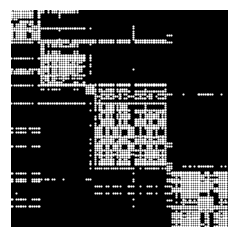

In [4]:
#sns.pairplot(df, hue="species")
from scipy.sparse import coo_matrix
m = np.matrix(filtered[1:])
if not isinstance(m, coo_matrix):
    m = coo_matrix(m)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, axisbg='black')
ax.plot(m.col, m.row, 's', color='white', ms=1)
ax.set_xlim(0, m.shape[1])
ax.set_ylim(0, m.shape[0])
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.figure.show()


# A plot of the excitatory synapse connectivity matrix


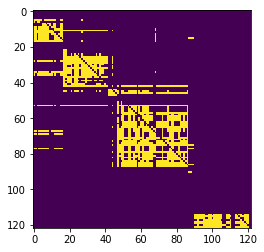

In [5]:
matplotlib.pyplot.imshow(plot_excit)   

# A plot of the inhibitory synapse connectivity matrix


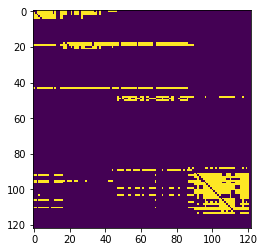

In [6]:
matplotlib.pyplot.imshow(plot_inhib)   


In [7]:
import pyNN.neuron as neuron
from pyNN.neuron import h
from pyNN.neuron import StandardCellType, ParameterSpace
assert len(set(pre_exc)) < len(pre_exc)
print(len(set(pre_exc)),len(pre_exc))


84 1941


In [8]:
import pyNN
pyNN.neuron.setup(timestep=1.0, min_delay=1.0)

from pyNN.random import RandomDistribution, NumpyRNG
from pyNN.neuron import STDPMechanism, SpikePairRule, AdditiveWeightDependence, FromListConnector, TsodyksMarkramSynapse
from pyNN.neuron import Projection, OneToOneConnector

In [9]:
#from neuron
from numpy import arange
import pyNN
from pyNN.utility import get_simulator, init_logging, normalized_filename
import random
import socket
from neuronunit.optimization import get_neab
#from pyNN import Assembly, PopulationView

sim = pyNN.neuron

# sim.setup(timestep=0.001, min_delay=delay, max_delay=1.0, **extra)
nproc = sim.num_processes()
host_name = socket.gethostname()
node_id = sim.setup(timestep=0.01, min_delay=1.0, **extra)
print("Host #%d is on %s" % (node_id + 1, host_name))
print("%s Initialising the simulator with %d thread(s)..." % (node_id, extra['threads']))
pop_size = len(index_exc)+len(index_inh)
pop_exc =  sim.Population(len(index_exc), sim.Izhikevich(a=0.02, b=0.2, c=-65, d=8, i_offset=0))
pop_inh = sim.Population(len(index_inh), sim.Izhikevich(a=0.02, b=0.25, c=-65, d=2, i_offset=0))

all_cells = pop_exc + pop_inh
assert len(all_cells) == (len(pop_exc) + len(pop_inh))

pop_pre_exc = all_cells[list(set(pre_exc))]
pop_post_exc = all_cells[list(set(post_exc))]
pop_pre_inh = all_cells[list(set(pre_inh))]
pop_post_inh =  all_cells[list(set(post_inh))]
print(pop_pre_exc)

assert len(pop_pre_exc) !=0      
assert len(pop_pre_inh) !=0       


Getting Rheobase cached data value for from AIBS dataset 354190013
attempting to recover from pickled file
Host #1 is on 75daaeebb99f
0 Initialising the simulator with 8 thread(s)...
Assembly(*[PopulationView(parent=Population(42, Izhikevich(<parameters>), structure=Line(x0=0.0, dx=1.0, z=0.0, y=0.0), label='population0'), selector=array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]), label="view of 'population0' with size 33"), PopulationView(parent=Population(98, Izhikevich(<parameters>), structure=Line(x0=0.0, dx=1.0, z=0.0, y=0.0), label='population1'), selector=array([ 0,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 48, 72, 73, 74, 75, 76, 77, 78, 79]), label="view of 'population1' with size 51")], label='assembly1')


In [10]:

print(len(pop_pre_exc) == len(pop_post_exc))
print(len(pop_pre_exc) , len(pop_post_exc))    
print(pop_post_inh)

for pe in pop_exc: 
    r = random.uniform(0.0, 1.0) 
    pe.set_parameters(a=0.02, b=0.2, c=-65+15*r, d=8-r**2, i_offset=0)

for pe in pop_inh: 
    r = random.uniform(0.0, 1.0) 
    
    pe.set_parameters(a=0.02+0.08*r, b=0.2-0.05*r, c=-65, d= 2, i_offset=0)
    
index_exc = [ i for i,d in enumerate(dfm) if '-' in d[0] ]
index_inh = [ i for i,d in enumerate(dfm) if '+' in d[0] ]   

NEXC = len(index_exc)
NINH = len(index_inh)

print(dir(sim.ArrayConnector))
conn = sim.ArrayConnector(plot_excit)
dir(conn)
#conn.connect()
conn.get_parameters()
ec = [ i for i in range(0,len(plot_excit)) ]
print(ec)
all_cells = all_cells[ec]


#prj_exc_exc = sim.Projection(all_cells, all_cells, conn, exc_syn, receptor_type='excitatory')

#prj_exc_exc = sim.Projection(all_cells[pre_inh[i] for i, j in enumerate(post_inh)],all_cells[j for i, j in enumerate(post_inh], 
#                                 conn, exc_syn, receptotype='excitatory')


False
84 119
Assembly(*[PopulationView(parent=Population(42, Izhikevich(<parameters>), structure=Line(x0=0.0, dx=1.0, z=0.0, y=0.0), label='population0'), selector=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41]), label="view of 'population0' with size 42"), PopulationView(parent=Population(98, Izhikevich(<parameters>), structure=Line(x0=0.0, dx=1.0, z=0.0, y=0.0), label='population1'), selector=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]), label="view of 'population1' with size 79")], label='assembly4')
['__class__', '__delattr__', '__dict__', '

In [11]:
ohub_index = 0
for x,i in enumerate(plot_excit):
    row_sum = np.sum(i)
    if ohub_index < row_sum:
        ohub_index = x


In [12]:

rng = NumpyRNG(seed=64754)
exc_distr = RandomDistribution('normal', [2.125, 10e-1], rng=rng)
exc_syn = sim.StaticSynapse(weight=exc_distr, delay=delay_distr)
inh_distr = RandomDistribution('normal', [5e-2, 2.1e-3], rng=rng)

inh_syn = sim.StaticSynapse(weight=inh_distr, delay=delay_distr)
rng = NumpyRNG(seed=64754)
delay_distr = RandomDistribution('normal', [50, 100e-3], rng=rng)

# Variation in propogation delays are very important for self sustaininig network activity.
# more so in point neurons which don't have internal propogation times.

stdp = STDPMechanism(
          weight=3.0, #0.02,  # this is the initial value of the weight
          delay="0.2 + 0.01*d",
          timing_dependence=SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                          A_plus=0.01, A_minus=0.012),
          weight_dependence=AdditiveWeightDependence(w_min=0.01, w_max=10.0))





In [13]:
first_set = set(pre_exc)
print(len(first_set))
second_set = set(post_exc)
print(len(second_set))

exc_targets = all_cells[pre_exc] 
exc_srcs = all_cells[post_exc]
inh_srcs = all_cells[pre_inh] # = []

#print(exc_srcs,inh_srcs)
inh_targets = all_cells[post_inh] # = []
conn = OneToOneConnector()
connections = {}
index_exc

exc_cells = all_cells[index_exc]
inh_cells = all_cells[index_inh]


#Name	Default value	Units	Description
#rate	0.0	s^`-1`	Mean spike frequency
#start	0.0	ms	Start time
#duration	10^9	ms	Duration of spike sequence

spike_source = sim.Population(len(all_cells), sim.SpikeSourcePoisson(rate=7.5))

spike_source.record('spikes')
print('excitatory sources')
print(exc_srcs)
print('excitatory targets')

print(exc_targets)
print(spike_source)

#pop_pre_exc = all_cells[pre_exc]
#pop_post_exc = all_cells[post_exc]
#pop_pre_inh = all_cells[pre_inh]
#pop_post_inh = all_cells[post_inh]


#connections['e1'] = sim.Projection(spike_source, all_cells, conn , exc_syn, receptor_type='excitatory')
#connections['e2'] = []
#connections['e3'] = []
#connections['ie'] = []

#for i, j in enumerate(post_exc):
#    connections['e2'].append(sim.Projection(pre_exc[i], post_exc[i], conn, stdp))

#for i, j in enumerate(post_exc):
#    connections['e3'].append(sim.Projection(pre_exc, post_exc, conn , exc_syn, receptor_type='excitatory'))

#connections['e2'] = sim.Projection(pop_pre_exc, pop_post_exc, conn, stdp)
#connections['e3'] = sim.Projection(pop_pre_exc, pop_post_exc, conn , exc_syn, receptor_type='excitatory')

#for i, j in enumerate(post_inh):
#    connections['ie'].append(sim.Projection(pre_inh, post_inh, conn , inh_syn, receptor_type='inhibitory'))

weight_exc_exc = 0.005
weight_exc_inh = 0.005
weight_inh_exc = 0.5
delay = 3.0
rng_seed = 42
stimulus_onset = 25.0
stimulus_sigma = 0.5
runtime = 150.0
##connector_exc_exc = sim.AllToAllConnector(weights=weight_exc_exc, delays=delay)
#connector_exc_inh = sim.AllToAllConnector(weights=weight_exc_inh, delays=delay)
#connector_inh_exc = sim.AllToAllConnector(weights=weight_inh_exc, delays=delay)

#for i, j in enumerate(post_inh):
#    prj_exc_inh = sim.Projection(all_cells[pre_inh[i]],all_cells[j],
#                                 conn, exc_syn, receptor_type='excitatory')
    
#    prj_inh_exc = sim.Projection(populations['inh'][i], populations['exc'][i],
#                                 connector_exc_exc, target='inhibitory')
    
    
    

84
119


IndexError: list index out of range

In [ ]:

#plot_excit is a boolean matrix
#for source,j in enumerate(plot_excit):
#    for target in j:
#        if target != 0:
#
#print(plot_excit)

In [ ]:
##
# Setup and run a simulation. Note there is no current injection into the neuron.
# All cells in the network are in a quiescent state, so its not a surprise that there are no spikes
##


neurons = all_cells    
sim = pyNN.neuron
arange = np.arange

import re

from pyNN.utility.plotting import Figure, Panel



In [ ]:



# === Build and instrument the network =======================================

exc_out_hubs = all_cells[ohub_index,92,43,121]
pulses = None
pulses = []


neurons.record(['v','spikes'])  # , 'u'])
neurons.initialize(v=-70.0, u=-14.0)


# === Run the simulation =====================================================

sim.run(500.0)


from pyNN.utility.plotting import Figure, Panel, comparison_plot, plot_spiketrains
data = neurons.get_data().segments[0]
v = data.filter(name="v")[0]
Figure(
    Panel(v, ylabel="Membrane potential (mV)", xticks=True,
          xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    annotations="Simulated with" 
)



In [ ]:
import pickle

data = neurons.get_data().segments[0]
with open('pickles/membrane_dynamics_hippocampome_file.p', 'wb') as f:
    pickle.dump(data,f)
#data = neurons.get_data().segments[0]
v0 =  neurons[(0,)].get_data().segments[0].filter(name="v")[0]
v1 =  neurons[(1,)].get_data().segments[0].filter(name="v")[0]


Below are plots of post synaptic targets in the from an arbitary source cell in the Entorhinal cortex, to targets taht are also in the EC.

In [ ]:
# Plot spike trains
import matplotlib.pyplot as plt

def plot_spiketrains(segment):
  """
  Plots the spikes of all the cells in the given segments
  """
  for spiketrain in segment.spiketrains:
      y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
      plt.plot(spiketrain, y, 'b')
      plt.ylabel('Neuron number')
      plt.xlabel('Spikes')
        
spikes = neurons.get_data("spikes").segments[0]
data = neurons.get_data().segments[0]
#print(data.spiketrains)
plot_spiketrains(data)


'''
Figure(
    comparison_plot(data.filter(name="v")[:], labels="neurons")
    #, ylabel="Membrane potential (mV)", xticks=True,
    #      xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    #annotations="Simulated with" 
)
'''


# === Clean up and quit ========================================================
#spikes = pop.get_data("spikes").segments[0]
#data = pop.get_data().segments[0]
#print(data.spiketrains)


#sim.end()


#print(spikes)
#m
#print(plt.backend)
#ax.figure.show()
#fig.savefig('connection_matrix.png')
#from IPython.display import Image
#Image(filename='connection_matrix.png') 
#df
#targets
#pd.DataFrame(targets).plot.hist()
#for k,v in targets.items():
#  pd.DataFrame(v).plot.hist()
#df

In [ ]:
#Image(filename='connection_matrix.png') 


In [ ]:



#u = data.filter(name="u")[0]
Figure(
    Panel(v0, ylabel="Membrane potential (mV)", xticks=True,
          xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    annotations="Simulated with" 
)



In [ ]:

#u = data.filter(name="u")[0]
Figure(
    Panel(v1, ylabel="Membrane potential (mV)", xticks=True,
          xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    annotations="Simulated with" 
)





```
# This is formatted as code
```

